In [11]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from numpy import polyfit
from StateObserver import *
from ReferenceConverter import *

MU = 2.0
SIGMA = 0.5

In [12]:
#Variables definition
Omega_r = None #Rotor rotational speed
Omega_g = None #Generator rotational speed
dOmega_r = None #Rotor rotational acceleration
dOmega_g = None #Generator rotational acceleration
Theta = None #Torsional displacement
dTheta = None #Torsional speed
Rho_v = 1.225 #Air density
v_t = None #Wind speed
v_bar = 10 #Average wind
vTil_L = 5 #Minimum wind turbulence intensity
vTil_U = 0.2 #Maximum wind turbulence intensity
R_r = 57.5 #Rotor radius
A_r = None #Rotor area
Rho_r = None #XXXXX
B_dt = 755.49 #D_exp_exp_exp_exp_exp_exp_exp_expamping of the drivetrain
K_dt = 2.7*(1e9) #Stiness of the drivetrain
J_r = 55*(1e6) #Inertia of the rotor
J_g = 55*(1e6) #Inertia of the drivetrain
C_pMax = 0.486 #Max. power coefficient
Lambda_opt = 7.6 #Optimal tip-speed ratio
Phi_opt = 0 #Optimal pitch angle 0 deg

In [13]:
class beta_estimator:
    def __init__(self):
        self.k = 1
        self.mu = 2
        self.sigma = 0.5
        self.num_trajectories = 50
        self.threshold = 500
        self.dt_lin = 1
        self.dt_exp = 0.1
        self.D_lin = [np.array([1e-16]) for i in range(self.num_trajectories)]
        self.D_exp = [np.array([1]) for i in range(self.num_trajectories)]
        self.D_M = np.array([0])
        self.b0s = ([np.array([0]) for i in range(self.num_trajectories)])
        self.b1s = ([np.array([0]) for i in range(self.num_trajectories)])
        self.b0_bar = 0
        self.b1_bar = 0
        self.beta = np.array([self.b0_bar,self.b1_bar])

    def update(self, f_w=1):
        np.random.seed(self.k)
        gamma = np.random.normal(self.mu, self.sigma)
        for i in range(self.num_trajectories):
            np.random.seed(i+self.k)
            eta = np.random.normal(self.mu, self.sigma)
            beta_0 = ([gamma*f_w + eta])
            self.b0s[i] = np.append(self.b0s[i],beta_0)
            D_lin = self.D_lin[i][-1] + beta_0*self.dt_lin
            self.D_lin[i] = np.append(self.D_lin[i],D_lin)

        for i in range(self.num_trajectories):
            np.random.seed(i+self.k)
            eta = np.random.normal(self.mu, self.sigma)
            beta_1 = gamma*f_w + eta
            self.b1s[i] = np.append(self.b1s[i],beta_1)
            D_exp = self.D_exp[i][-1] + beta_1*self.D_exp[i][-1]*self.dt_exp
            self.D_exp[i] = np.append(self.D_exp[i],D_exp)

            
        b0s = np.array(self.b0s).T
        b1s = np.array(self.b1s).T
        self.b0_bar = np.array([np.mean(b0s[i]) for i in range(len(b0s))])
        self.b1_bar = np.array([np.mean(b1s[i]) for i in range(len(b1s))])

        D = (np.array(self.D_lin)+np.array(self.D_exp)).T
        self.D_M = np.array([np.mean(D[i]) for i in range(len(D))])
        self.beta = np.array([self.b0_bar[-1],self.b1_bar[-1]])
        self.k = self.k + 1
        
beta = beta_estimator()

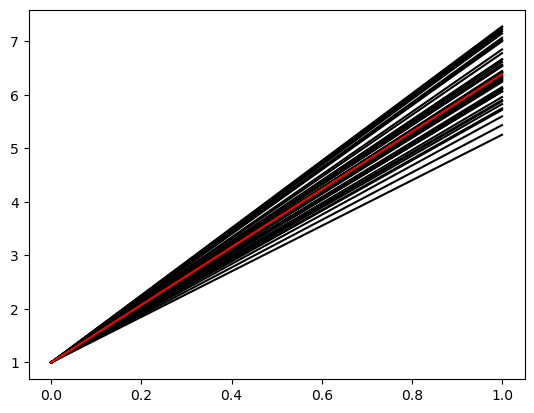

In [14]:
beta.update()
for i in range(len(beta.D_lin)):
    plt.plot(beta.D_lin[i]+beta.D_exp[i], color='black')
plt.plot(beta.D_M, color='red')

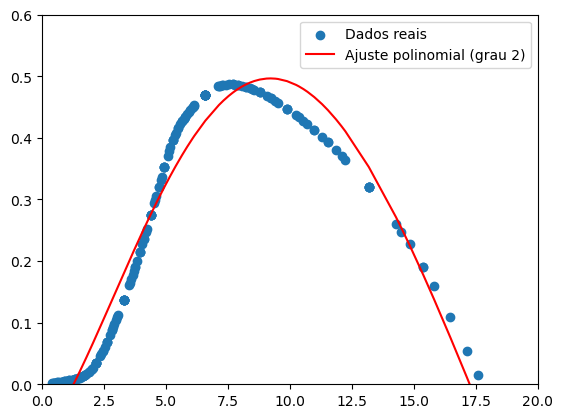

In [15]:
path = 'CpVersusTSR&Pitch_WT_Perf_V1.csv'
df = pd.read_csv(path,header=None)
x = df.iloc[:,0].values
y = [df.iloc[:,i+6].values for i in range(6)]
ymax = [np.max(df.iloc[:,i+6].values) for i in range(6)]
x_max = [np.where(df.iloc[:,i+6].values==np.max(df.iloc[:,i+6].values)) for i in range(6)]

coeffs = polyfit(x, y[0], 5)
def Cp_calc(x):
    return coeffs[0] * x**5 + coeffs[1] * x**4 + coeffs[2] * x**3 + coeffs[3] * x**2 + coeffs[4] * x**1 + coeffs[5] * x**0 

plt.scatter(x, y[0], label='Dados reais')
plt.plot(x, Cp_calc(x), color='r', label='Ajuste polinomial (grau 2)')
plt.xlim(0, 20)
plt.ylim(0, 0.6)
plt.legend()
plt.show()

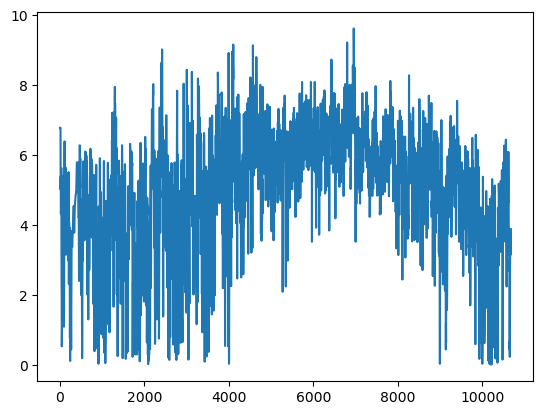

In [16]:
path  = 'data_tibau.csv'
df = pd.read_csv(path, header=None)
v = df.iloc[:,1].values
plt.plot(v)

In [20]:
class Dynamics:
    def __init__(self):
        self.k = 0
        self.Bdt = 755.49
        self.Kdt = 2.7*1e9
        self.Jg = 55*1e6
        self.Jr = 55*1e6    
        self.wr = 1
        self.wg = 1
        self.ot = 0
        self.tau_r = 0
        self.tau_g = 0
        self.uk = 0
        self.RHOv = 1.225 #Air density
        self.Ar = np.pi * 57.5**2 #Rotor area
        self.Rr = 57.5 
        self.Cp_Max = 0.468
        self.lmbd_opt = 7.6
        self.D_hat = 0
        self.Dmax = 1000
        self.rul_ref = 10000
        self.beta = beta_estimator()
        self.beta_ref = (self.Dmax-self.D_hat)/self.rul_ref
        self.ED_t = 1e-16
        self.K1 = 0
        self.K2 = 0

        self.A=np.array([[-self.Bdt/self.Jr, self.Bdt/self.Jr, -self.Kdt/self.Jr],
                         [self.Bdt/self.Jg, -self.Bdt/self.Jg, self.Kdt/self.Jg],
                         [1, -1, 0]])
        self.B = np.array([[1/self.Jr, 0],
                           [0, -1/self.Jg],
                           [0, 0]])
        
    def Lmbd(self,v):
        return self.wr*self.Rr/v
    
    def Lmbd_star(self):
        return self.lmbd_opt+self.uk
    
    def Cp(self,v):
        #print('lamb',self.Lambda(v))
        return (self.Cp_Max*self.Lmbd(v)**3)/(self.lmbd_opt**3)
    
    def Kmppt(self):
        return 0.5*self.RHOv*self.Ar*(self.Rr**3)*self.Cp_Max/(self.lmbd_opt**3)

    def Beta_ref(self):
        beta = (self.Dmax-self.D_hat)/self.rul_ref
        return beta
    
    def Tau_r(self):
        tau_r = 0.5*self.RHOv*self.Ar*self.Cp(v)*(v**3)/(self.wr)
        return tau_r
    
    def Tau_g(self):
        tau_g = self.Kmppt()*(self.wg**2)
        return tau_g
    
    def PD_t(self):
        return self.Bdt((self.wr-self.wg)**2)

    def ED_t_(self):
        self.ED_t = self.ED_t + self.PD_t()

    def PG_t(self):
        return self.tau_g*self.wg



d = Dynamics()

In [27]:
class FeedbackController:
    def __init__(self):
        """
        Inicializa o Controlador de Feedback (Degradation-Rate Controller).

        Args:
            gamma_min (float): O valor mínimo esperado para o parâmetro de incerteza ~γ.
            gamma_max (float): O valor máximo esperado para o parâmetro de incerteza ~γ.
        """
        # Ganhos do controlador K = [K1, K2]
        self.K = None
        self.K1 = None
        self.K2 = None

        #lambda ótimo
        self.lmbd_opt = 7.6
        self.vwL = 0.2
        self.vwU = 5
        self.Bdt = 755.49
        self.Rr = 57.5

        # Parâmetros para o LQR Robusto
        self.gamma_min = (self.Bdt*(self.vwL**2))*2*self.lmbd_opt/(self.Rr**2)
        self.gamma_max = (self.Bdt*(self.vwU**2))*2*self.lmbd_opt/(self.Rr**2)

        # Estados internos do controlador
        self.u_k = 0.0 # Valor inicial para u_{k-1}
        self.z_k = 0.0         # Valor inicial para o erro integral z_k

        
        
    def solve_lqr_gain(self, Q=np.diag([1, 2.5e-5]), R=np.array([[100.0]])):
        """
        Calcula os ganhos ótimos K1 e K2 usando a solução LMI para o problema
        de LQR Robusto descrito na Seção 4.4.2 do artigo.
        
        Args:
            Q (np.array): Matriz de custo do estado (2x2).
            R (np.array): Matriz de custo do controlo (1x1).
        """
        n = 2 # Dimensão do estado x_k = [u_{k-1}, z_k]
        m = 1 # Dimensão da entrada u_k

        # --- Formulação do Problema LMI (Seção 4.4.2) ----
        # 1. Definir as variáveis da LMI
        P = cp.Variable((n, n), symmetric=True)
        Y = cp.Variable((m, n))
        W = cp.Variable((n + m, n + m), symmetric=True)

        # 2. Definir as matrizes de custo estendidas M e N (Equação 39)
        M = np.vstack([np.sqrt(Q), np.zeros((m, n))])
        N = np.vstack([np.zeros((n, m)), np.sqrt(R)])

        # 3. O sistema politópico tem 2 vértices (extremos de ~γ)
        # Vértice 1: Corresponde a gamma_min
        # Vértice 2: Corresponde a gamma_max
        A_vertices = [
            np.array([[0, 0], [self.gamma_min, 1]]),
            np.array([[0, 0], [self.gamma_max, 1]])
        ]
        B = np.array([[1], [0]])

        # 4. Definir as restrições da LMI para TODOS os vértices
        constraints = [P >> 1e-6 * np.eye(n)] # P deve ser definida positiva

        for A in A_vertices:
            # Restrição de estabilidade (Equação 44)
            lmi_stability = cp.bmat([
                [P, (A @ P - B @ Y)],
                [(P @ A.T - Y.T @ B.T), P]
            ])
            constraints += [lmi_stability >> 0]

        # Restrição da função de custo (Equação 47)
        lmi_cost = cp.bmat([
            [W, (M @ P - N @ Y)],
            [(P @ M.T - Y.T @ N.T), P]
        ])
        constraints += [lmi_cost >> 0]
        
        # 5. Definir e resolver o problema de otimização
        objective = cp.Minimize(cp.trace(W))
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.SCS)

        # 6. Calcular os ganhos K a partir da solução
        if problem.status in ["infeasible", "unbounded"] or P.value is None:
            print(f"Falha ao resolver a LMI do LQR. Status: {problem.status}")
            return None

        P_val = P.value
        Y_val = Y.value
        
        # K = Y * inv(P)
        K_val = Y_val @ np.linalg.inv(P_val)
        self.K = K_val.flatten()
        self.K1, self.K2 = self.K[0], self.K[1]
        
        print(f"Ganhos LQR calculados com sucesso: K1 = {self.K1:.4f}, K2 = {self.K2:.4f}")
        return self.K
        
    def compute_input(self, beta_hat, beta_ref, dt=1):
        """
        Calcula a ação de controlo u_k (ou seja, Δλ) com base na lei de controlo
        da Equação (83).

        Args:
            beta_hat (float): A taxa de degradação atual estimada (saída do observador).
            beta_ref (float): A taxa de degradação de referência (saída do conversor).
            dt (float): O período de amostragem.
        
        Returns:
            float: A ação de controlo calculada, u_k.
        """
        if self.K is None:
            raise RuntimeError("Os ganhos K não foram calculados. Chame 'solve_lqr_gain' primeiro.")
            
        # 1. Atualizar o erro integral (Equação 84, em tempo discreto)
        self.z_k += (beta_hat - beta_ref) * dt
        
        # 2. Calcular a ação de controlo u_k (Equação 83)
        u_k = -self.K1 * self.u_k - self.K2 * self.z_k
        
        # 3. Atualizar o estado da ação anterior para a próxima iteração
        self.u_k = u_k
        
        return u_k

In [30]:
observer = StateObserver(ts=10)
converter = ReferenceConverter()
L_calculado = observer.solve_lmi_gain()

observer.update_state(y_k=1e-16)
D_hat, beta_hat = observer.x_hat
#print(converter.beta_ref, converter.rul_ref)

converter.update(D_hat=D_hat,k=1)
beta_ref = converter.beta_ref
#print(converter.beta_ref, converter.rul_ref)

controller = FeedbackController()
K_calculado = controller.solve_lqr_gain()
#print(controller.u_k,controller.z_k, )
controller.compute_input(beta_hat,beta_ref)
#print(controller.u_k,controller.z_k, )


Ganho L calculado com sucesso: [0.08110147 0.00119532]
Ganhos LQR calculados com sucesso: K1 = 0.0041, K2 = 0.0002


2.9202603989574336e-07